# 🎧 Audio analysis with Parselmouth in Python
_by Marianne de Heer Kloots, June 2025_

To explore audio processing tools for analyzing speech data, we'll work with a pre-processed subset of audio recordings from the [Tragic Talkers](https://cvssp.org/data/TragicTalkers/) dataset — a set of excerpts from the "Romeo and Juliet" drama played by two actors. The subset we'll use is extracted from the dataset's development split, and the audio is downsampled from 48 to 16 kHz (this is needed for the models we'll use in the second and third notebook of this tutorial). We'll also use the dataset's speech activity annotations and human-validated transcripts, to compare against the output of the automated pipelines we'll explore. Check out the [pre-processing scripts](https://github.com/mdhk/unboxing_speech_tutorial/tree/main/preprocessing) in the tutorial repository if you want to know more about (or make changes in) creating the pre-processed subset.

In this notebook, we'll start analyzing some basic signals extracted from just the audio recordings in the dataset, using the [Parselmouth](https://parselmouth.readthedocs.io/en/stable/) package to access functionality from the [Praat](https://www.fon.hum.uva.nl/praat/) programme in Python. Good packages exist for native audio processing in Python (e.g. [librosa](https://librosa.org/)), but Praat contains a lot of very useful algorithms and analysis tools for processing speech data specifically, and the Parselmouth package allows you to access them within your Python workflow.

Each excerpt from the Shakespeare play in the Tragic Talkers dataset is recorded by 38 (!) different microphones, placed at different locations around the speakers. In this tutorial we'll look at the recordings from three different microphone tracks to examine the effect of recording quality on the outputs of our tools: two tracks recorded by the speakers' [lavalier microphones](https://en.wikipedia.org/wiki/Lavalier_microphone) (microphone tracks `17` and `18`), and one track from the [ambisonic](https://en.wikipedia.org/wiki/Ambisonics) microphone (track `19`) hanging from the ceiling. We'll first use Parselmouth to examine the different acoustic signals recorded by these microphones, by examining their waveforms, and computing the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) and [temporal envelope](https://en.wikipedia.org/wiki/Temporal_envelope_and_fine_structure).

Run the cells below to download the preprocessed Tragic Talkers subset, install the parselmouth library and import the needed libraries and helper functions (no need to closely read their contents).

In [1]:
# @title Download data
!rm -rf 'sample_data'
!gdown -qq 1RXQ3u5RRsSq50mQWKDTj1rpKMUnTqIh0
!unzip -qq tragictalkers_speech_subset.zip
!rm tragictalkers_speech_subset.zip

In [2]:
# @title Install libraries
!pip install praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 41.3 MB/s eta 0:00:00


In [3]:
# @title Import libraries & helper functions
import parselmouth as pm
from parselmouth.praat import call
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import IPython.display as ipd
from IPython.display import Audio
import glob
sns.set()

# helper functions
def draw_spectrogram(spectrogram, dynamic_range=70):
    """
    Spectrogram plotting function from the Parselmouth tutorial:
    https://parselmouth.readthedocs.io/en/stable/examples/plotting.html
    """
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='inferno')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlim([spectrogram.xmin, spectrogram.xmax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def find_wav_filepath(recording_name, mic_id):
    """
    Find the audio file for the specified recording and microphone.
    """
    return glob.glob(f'audio_subset/{recording_name}/{mic_id}-*.wav')[0]

def audio_player(audio_file):
    return ipd.display(Audio(audio_file))

Let's load the recording for one of the excerpts in the dataset. `interactive2_t1` is (a different recording of) the same excerpt as visualized in Figure 5 of the [Tragic Talkers dataset paper](https://cvssp.org/data/TragicTalkers/CVMP22-TragicTalkers.pdf):
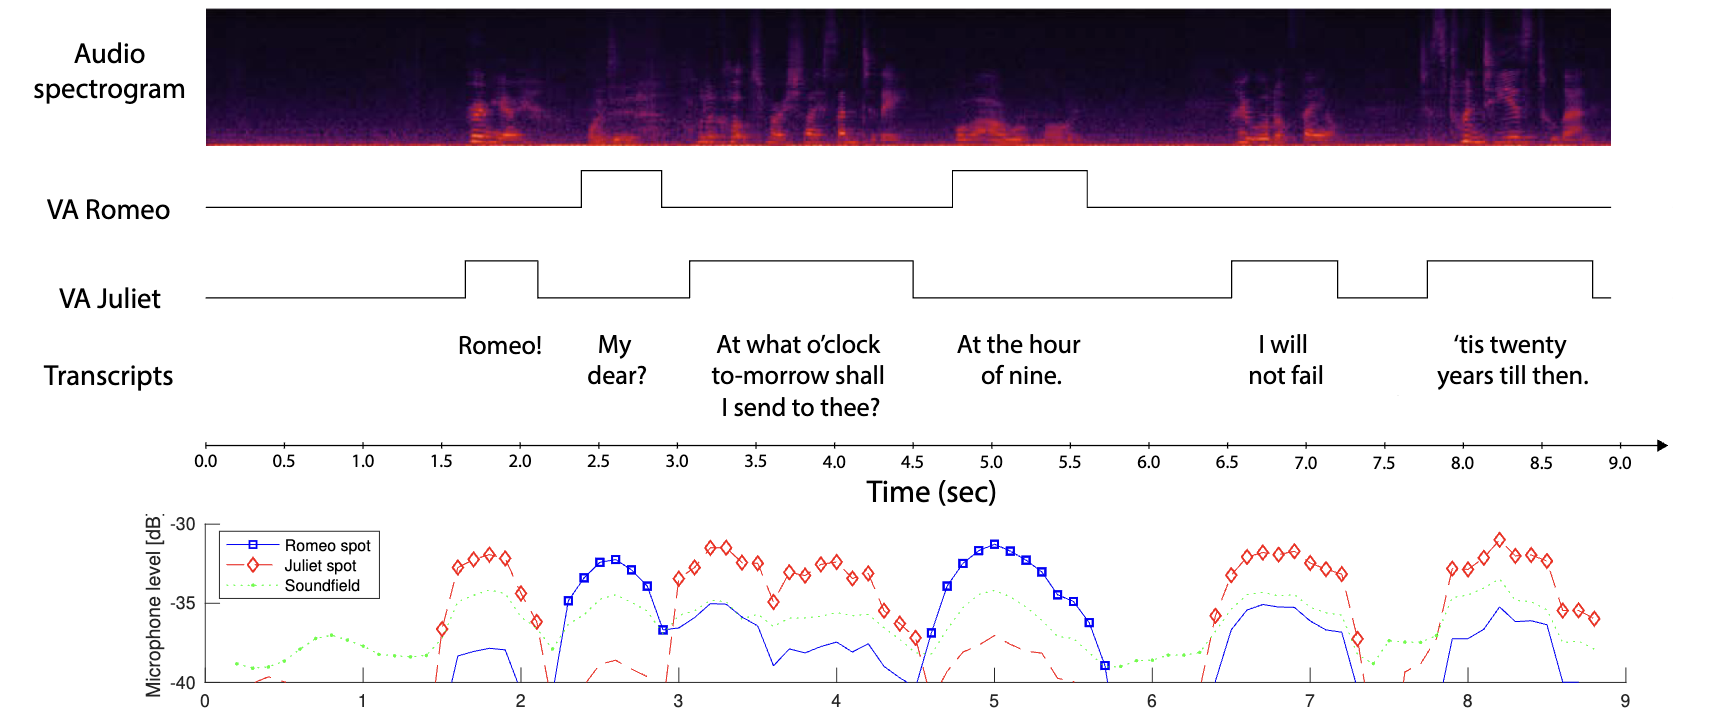

If you want, you can also load other recordings in the dataset by changing the `rec_name` variable below; navigate to the `audio_subset/` directory in the file explorer (click the folder 📁 icon to the left of this notebook) and see the titles of its subfolders for the different recording names.

In [4]:
rec_name = 'interactive2_t1'

# we'll look at recordings from 3 microphones: two speaker lav microphones (17 & 18),
# and one ambisonic one hanging from the ceiling (19)
mic_ids = [
    17, # romeo
    18, # juliet
    19  # ceiling
]
rec_files = {
    mic_id: find_wav_filepath(rec_name, mic_id)
    for mic_id in mic_ids
}

In [5]:
# let's load the sounds recorded by the different microphones
sounds = {
    mic_id: pm.Sound(filepath)
    for mic_id, filepath in rec_files.items()
}

# let's only look at the first 9 seconds
start_time = 0
end_time = 9
sounds = {
    mic_id: snd.extract_part(from_time=start_time, to_time=end_time)
    for mic_id, snd in sounds.items()
}

# we've now loaded the three microphone tracks as parselmouth sounds
sounds

{17: <parselmouth.Sound at 0x78afc4824070>,
 18: <parselmouth.Sound at 0x78afc40dc7b0>,
 19: <parselmouth.Sound at 0x78afc40dc5f0>}

We can now listen to the audio signals recorded by the different microphones.
> **Exercise:** What differences in recording quality do you notice across microphones? Which audio recordings do you think would be most suitable for use in our further analysis steps (automatic speaker diarization and text transcription)?

In [6]:
print("Romeo's lav mic")
audio_player(rec_files[17])
print("Juliette's lav mic")
audio_player(rec_files[18])
print("The ambisonic ceiling mic")
audio_player(rec_files[19])

Romeo's lav mic


Juliette's lav mic


The ambisonic ceiling mic


In the cell below, we use Parselmouth functionality to easily plot the waveform and spectrogram signals for one of the microphone tracks (adapting code from the [Parselmouth plotting tutorial](https://parselmouth.readthedocs.io/en/stable/examples/plotting.html) by Yannick Jadoul).

> **Exercise:** Change the `mic_id` variable in the cell below to plot the signals for the three different microphone tracks. What differences do you see in the waveform and spectrogram signals between the different microphone tracks? How do these correspond to the qualitative differences you observed from listening to the tracks before?

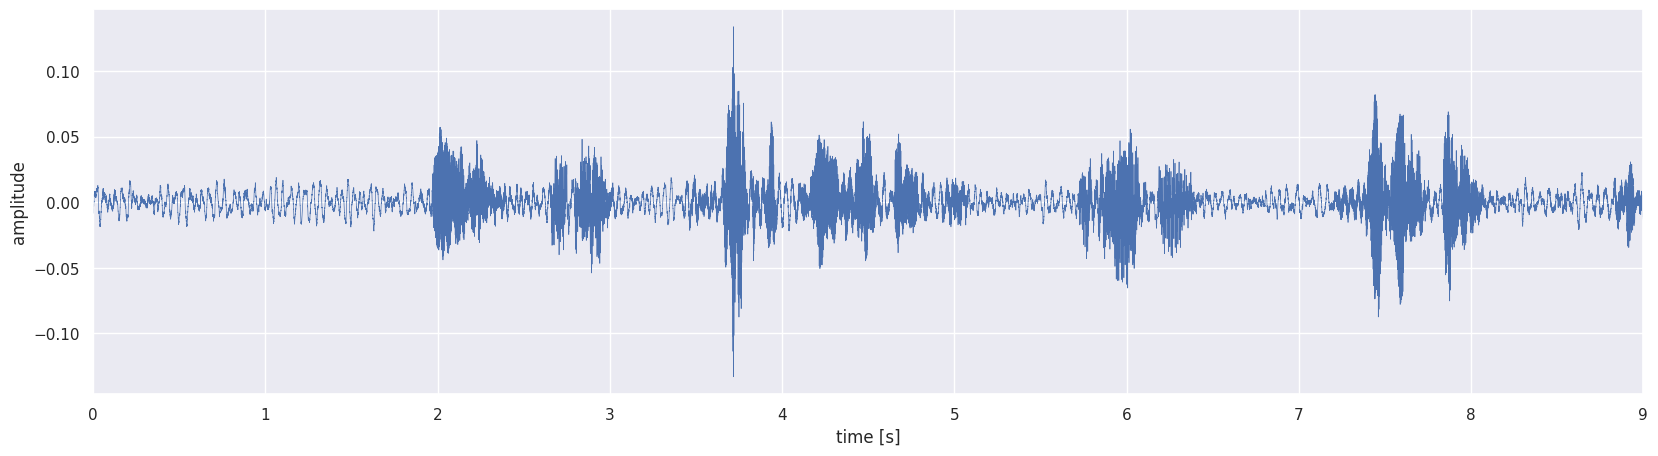

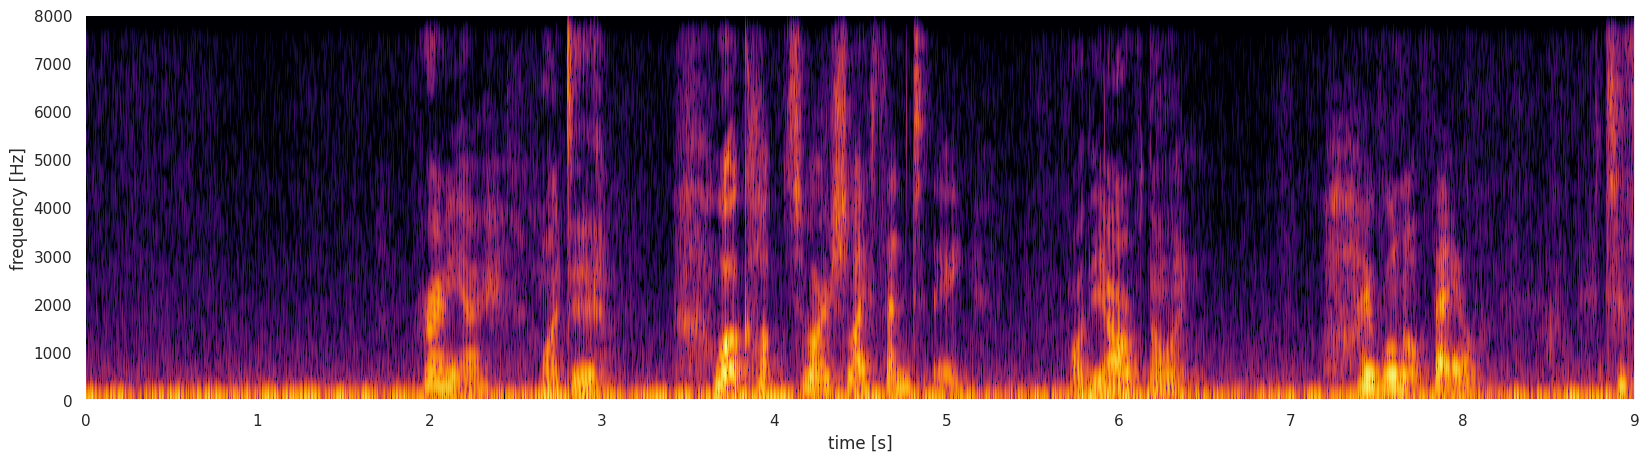

In [7]:
# analyze sound for this microphone track
mic_id = 19
snd = sounds[mic_id]

# plot waveform
plt.figure(figsize=(20,5))
plt.plot(snd.xs(), snd.values.T, linewidth=0.5)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

# extract & plot spectrogram
spectrogram = snd.to_spectrogram(maximum_frequency=8000)
plt.figure(figsize=(20,5))
draw_spectrogram(spectrogram)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

Some Praat functions are implemented into the [Parselmouth API](https://parselmouth.readthedocs.io/en/latest/api/parselmouth.html#module-parselmouth) directly. However, much more functionality can be accessed by calling Praat commands using the [`parselmouth.praat.call`](https://parselmouth.readthedocs.io/en/latest/api/parselmouth.praat.call.html) function (if you're interested in running your existing Praat scripts from Python, the `parselmouth.praat` module also contains a [`run`](https://parselmouth.readthedocs.io/en/latest/api/parselmouth.praat.run.html) function to execute a full script at once).

The cell below translates an existing Praat script for extracting the temporal envelope from a speech sound into Parselmouth commands, so you can compute and explore the results in Python. Check out [this video](https://www.youtube.com/watch?v=qp1G3a2g8r0) by Matt Winn if you're interested to learn more about the different components of the amplitude computation and how they correspond to Praat objects and operations!

In [8]:
def get_sound_envelope(sound):
  """
  Estimate the sound envelope through Praat's intensity computation.
  Adapted from Praat script by Matt Winn:
  https://github.com/ListenLab/Praat/blob/master/Hilbert_transform_praat_native.txt
  """
  sound_duration = sound.get_total_duration()
  sound_sampfreq = sound.get_sampling_frequency()
  sound_intensity = sound.to_intensity(800)
  sound_env = call(call(call(call(call(call(
      sound_intensity,
      "Down to IntensityTier"),
      "To AmplitudeTier"),
      "Down to TableOfReal"),
      "To Matrix"),
      "Transpose"),
      "To Sound (slice)", 2)
  call(sound_env, "Scale times to", 0, sound_duration)
  sound_env = call(call(
      sound_env,
      "Resample...", sound_sampfreq, 5),
      "Filter (pass Hann band)...", 0, 5, 5)
  sound_env = sound_env.as_array().flatten()
  return sound_env

> **Exercise:** Change the `mic_id` variable in the cell below to look explore the computed envelopes for the different microphone tracks. Could these signals potentially give you a clue about which speaker was talking at what time segments throughout the recording, and how?

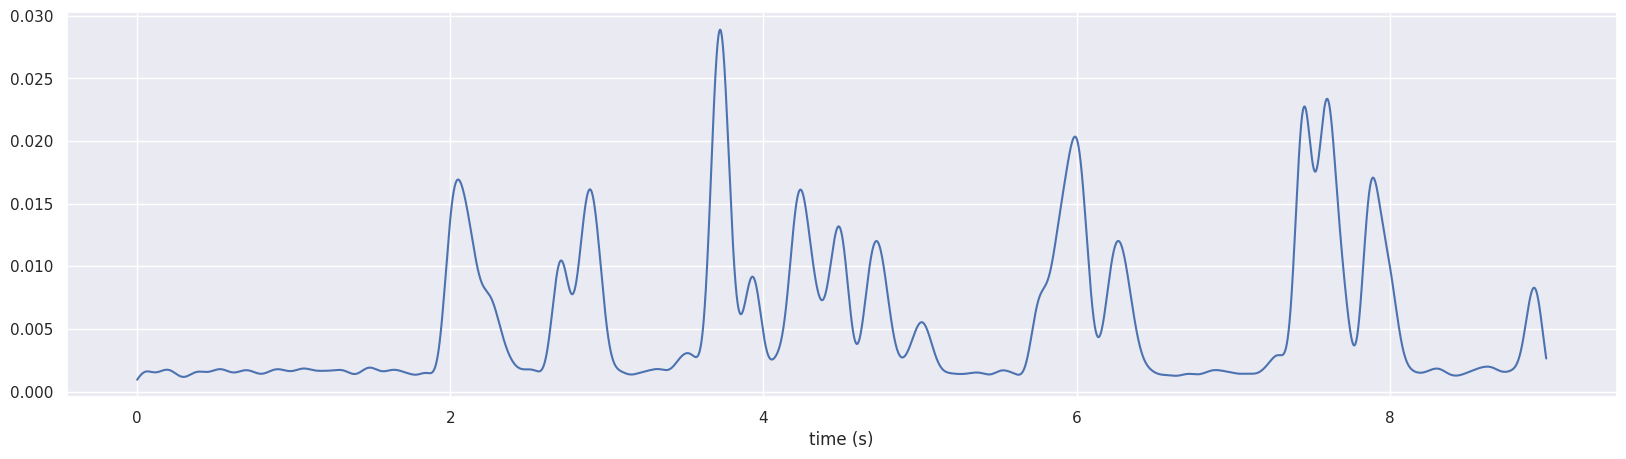

In [9]:
mic_id = 19
sound_env = get_sound_envelope(sounds[mic_id])

plt.figure(figsize=(20,5))
sns.lineplot(
    x=sounds[mic_id].xs(),
    y=sound_env
)
plt.xlabel('time (s)')
plt.show()

⏩ **Want to learn more** about other audio processing functionalities enabled through Parselmouth? Check out some other tutorials from the Parselmouth documentation, for example on [batch processing of files](https://parselmouth.readthedocs.io/en/latest/examples/batch_processing.html) or [pitch manipulation](https://parselmouth.readthedocs.io/en/latest/examples/pitch_manipulation.html).